# Plot results

## Import modules

In [1]:
# Reload autmatically external imports
%load_ext autoreload
%autoreload 2

# Add the function path
import sys
sys.path.insert(0, '../functions')

# Import personal external functions
import utils
import models
import plot

# For plots
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Check memory usage
utils.print_memory_usage()

Using TensorFlow backend.



Memory usage: 48.9%


## Get data

In [2]:
sla = utils.get_data()

<xarray.DataArray 'sla' (member: 51, time_counter: 1533, y: 48, x: 40)>
dask.array<shape=(51, 1533, 48, 40), dtype=float32, chunksize=(1, 1533, 48, 40)>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1979-01-03T12:00:00 ... 1999-12-29T11:58:56
    nav_lat       (y, x) float32 -32.58632 -32.58632 ... -22.174746 -22.174746
    nav_lon       (y, x) float32 0.25 0.5 0.75 1.0 1.25 ... 9.25 9.5 9.75 10.0
  * member        (member) object 'e001' 'e002' 'e003' ... 'e049' 'e050' 'emean'
Dimensions without coordinates: y, x
Attributes:
    units:      m
    long_name:  Sea level anomalies

Memory usage: 49.4%


## Compare loss functions

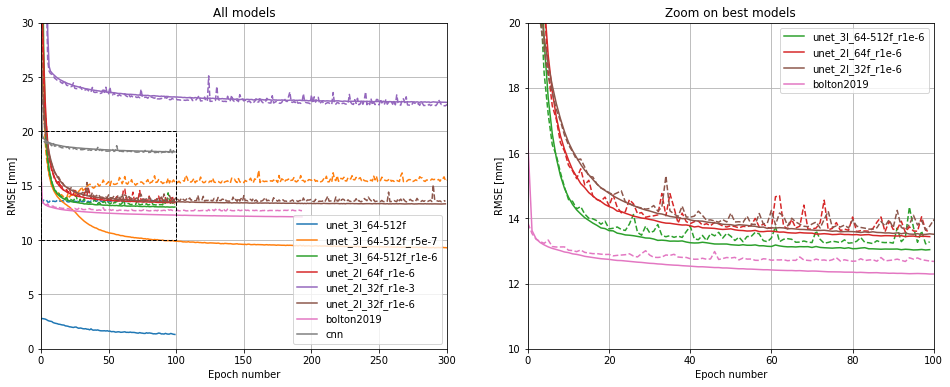

In [3]:
model_names = ['unet_3l_64-512f', 'unet_3l_64-512f_r5e-7', 'unet_3l_64-512f_r1e-6', 
               'unet_2l_64f_r1e-6', 'unet_2l_32f_r1e-3', 'unet_2l_32f_r1e-6', 
               'bolton2019', 'cnn']

path = '../results/sla_5d/south_atlantic/agulhas_eddies_48x40'
list_colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

for i, model_name in enumerate(model_names):
    history = models.get_history_history(path+'/'+model_name+'/')
    ax[0].plot(np.sqrt(history['loss'])*1e3, label=model_name, color=list_colors[i])
    ax[0].plot(np.sqrt(history['val_loss'])*1e3, color=list_colors[i], linestyle='--')
    
    # Zoom on best models
    if model_name in ['unet_2l_32f_r1e-6', 'unet_2l_64f_r1e-6', 'unet_3l_64-512f_r1e-6', 'bolton2019']:
        ax[1].plot(np.sqrt(history['loss'])*1e3, label=model_name, color=list_colors[i])
        ax[1].plot(np.sqrt(history['val_loss'])*1e3, color=list_colors[i], linestyle='--')
        
ax[0].set_ylim(0,30)
ax[0].set_xlim(0,300)
ax[0].set_title('All models')
rect = Rectangle((0,10), 100, 10, linewidth=1, linestyle='--', edgecolor='black', facecolor='none', zorder=10)
ax[0].add_patch(rect)

ax[1].set_ylim(10,20)
ax[1].set_xlim(0,100)
ax[1].set_title('Zoom on best models')

for ax in ax:
    ax.grid()
    ax.set_xlabel('Epoch number')
    ax.set_ylabel('RMSE [mm]')
    ax.legend()

plt.show()

Dashed lines correspond to validation and plain lines to learning.

## Build model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 40, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 40, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 48, 40, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 24, 20, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

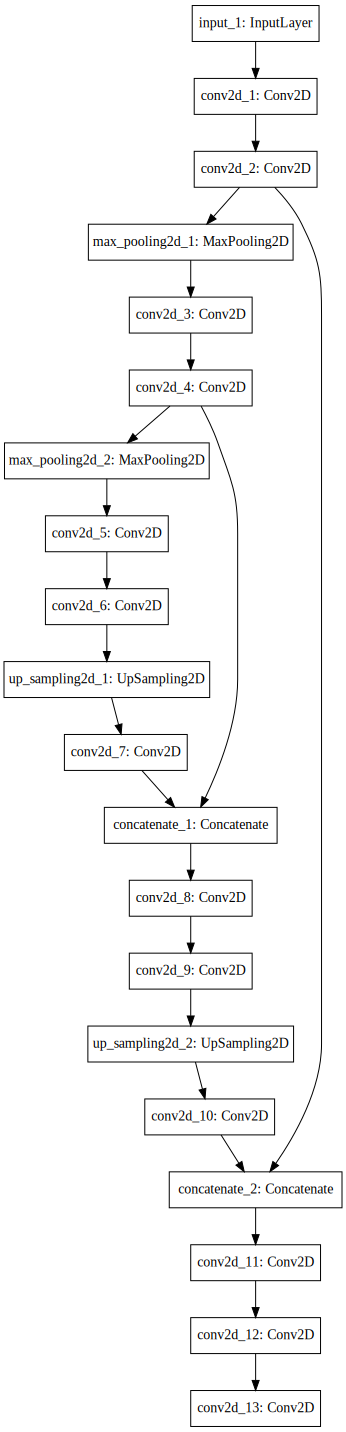

In [4]:
# model_names = ['unet_3l_64-512f', 'unet_3l_64-512f_r5e-7', 'unet_3l_64-512f_r1e-6', 
#                'unet_2l_64f_r1e-6', 'unet_2l_32f_r1e-3', 'unet_2l_32f_r1e-6', 
#                'bolton2019', 'cnn']

model_name = 'unet_2l_32f_r1e-6'
model_path = path = '../results/sla_5d/south_atlantic/agulhas_eddies_48x40/'+model_name+'/'

model = models.build_model(sla.y.shape[0], sla.x.shape[0], name=model_name)
model.summary()
models.plot_model(model)

## Convert data for keras

In [5]:
# We split the dataset in 80% for the training, 10% for the validation and 10% for testing
n_train = 40
n_val = 5
n_test = 5

# x: input values are the total field
# y: output values are the ensemble mean (duplicated for each member)
(x_train,y_train),(x_val,y_val),(x_test,y_test) = models.data_to_keras(sla.fillna(0).values,
                                                                       model.input_shape, model.output_shape, 
                                                                       n_train=n_train, n_val=n_val, n_test=n_test)

utils.print_memory_usage()


Memory usage: 74.3%


## Run model

In [6]:
# # save_all: full model and full history
# # save_light: only weights and history.history/params

# history = models.run_model(model, x_train, y_train, x_val, y_val, lr=1e-4, batch_size=32, epochs=300, patience=30)

## Load weights

In [7]:
model.load_weights(model_path+'weights.h5')
history_history = models.get_history_history(model_path)
history_params = models.get_history_params(model_path)

## Plot learning curve

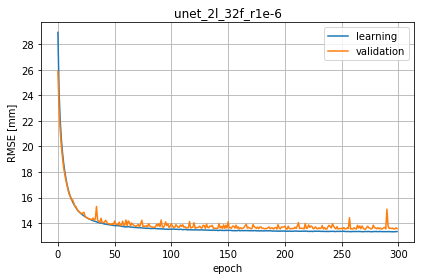

In [8]:
plot.plot_learning_curve(history_history, model_name)

## Plot results

/home/lalandem/anaconda3/envs/keras/lib/python3.6/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


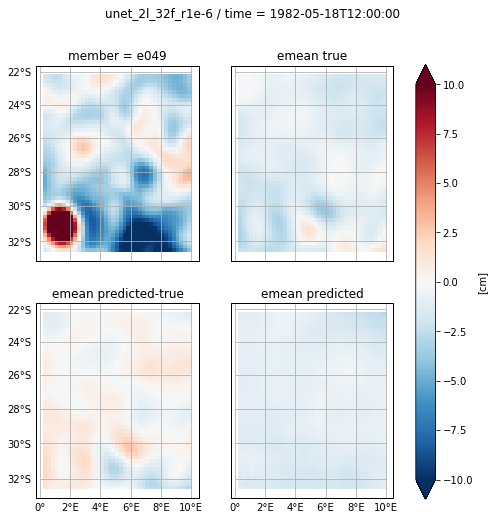

In [9]:
x_type = 'test' # train / val / test
random = True
member='e048'
time='2014-08-16T12:01:04'

if x_type == 'test':
    x = x_test
elif x_type == 'val':
    x = x_val
elif x_type == 'train':
    x = x_train

plot.plot_results(model, x, x_type, sla.copy(), random=random, member=member, time=time, 
                n_train=n_train, n_val=n_val, n_test=n_test)